<a href="https://colab.research.google.com/github/afnanetman/Head-Pose-Estimation/blob/main/Head_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
%%capture
!pip install mediapipe

In [194]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,f1_score
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

In [195]:
#path = '/content/drive/MyDrive/AFLW2000-3D.zip'

In [196]:
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [197]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

## Data Extraction And Preparation

In [198]:
def getLandMarks(name,path='/content/AFLW2000/'):
  # choosing random image
  random_file = name
  Xs=[]
  Ys=[]

  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread(path+random_file+'.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                Xs.append(x)
                Ys.append(y)
      return(Xs,Ys)



In [204]:
def draw_axis(name,pitch,yaw,roll,path='/content/drive/MyDrive/Head-pose tests/', tdx=None, tdy=None, size = 100):
    faceModule = mediapipe.solutions.face_mesh
    faces = faceModule.FaceMesh(static_image_mode=True)
    img = cv2.imread(path+name+'.jpg')
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
      results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      tdx = int(results.multi_face_landmarks[0].landmark[6].x * img.shape[1])
      tdy = int(results.multi_face_landmarks[0].landmark[6].y * img.shape[0])

       # height, width = img.shape[:2]
       # tdx = width / 2
       # tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    
    return img



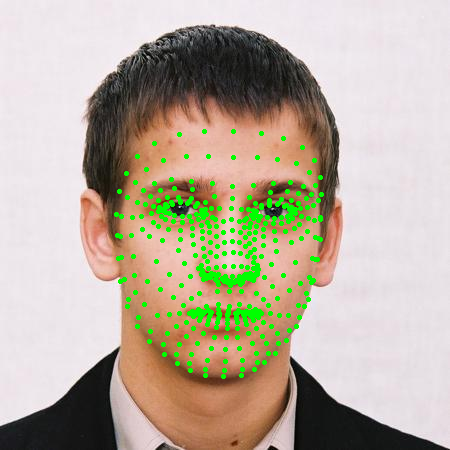

In [205]:
drawPoints('image00053')

In [207]:
def drawPos(name,customPose=None,path='/content/AFLW2000/'):
  random_file = name
  image = cv2.imread(path+random_file+'.jpg')
  # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
  # extracting the labels 3 angels
  if (customPose!=None) : pose_para=customPose
  else : 
    mat_file = sio.loadmat(path+random_file+'.mat')
    pose_para = mat_file["Pose_Para"][0][:3]
  pitch = pose_para[0]
  yaw = pose_para[1]
  roll = pose_para[2]
  cv2_imshow(draw_axis(name,pitch,yaw,roll,path=path))

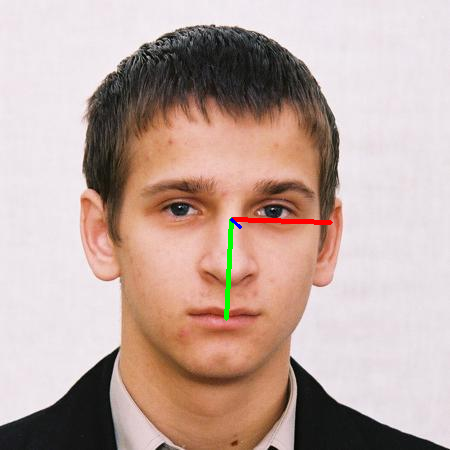

In [208]:
drawPos('image00053')

In [209]:
mylist = [f for f in glob.glob("/content/AFLW2000/*.mat")]

In [210]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines

In [211]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [212]:
class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        labels = pose[:3]
        cont_labels = [yaw, pitch, roll]

        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return img, labels, cont_labels, self.X_train[index]

    def __len__(self):
        #self.length = 2000
        return self.length

In [213]:
demo=AFLW2000("/content/AFLW2000/*.mat",'/content/AFLW2000/')

get yaw, pitch, roll for all images

In [214]:
labels=[]
imgs=[]
for i in range(demo.length):
  pla=demo.__getitem__(i)
  x = np.array(pla[1], dtype=np.float32)
  labels.append(x)
  imgs.append(pla[3])


In [215]:
df = pd.DataFrame(labels,columns=['yaw', 'pitch', 'roll'],index=imgs) #convert to a dataframe

In [216]:
df.head()

,yaw,pitch,roll
image00002,-0.399231,0.018227,0.085676
image00004,0.470065,1.189533,0.300959
image00006,-0.184650,0.881137,-0.236852
image00008,-0.175379,0.299208,-0.373374
image00010,-0.882169,1.198004,-1.033374


In [217]:
filenames = get_list_from_filenames('/content/AFLW2000/*.mat')

In [219]:
filenames.sort()

get landmarks for all images

In [220]:
len(getLandMarks(filenames[2])[1])

468

In [221]:
landmarksX = []
landmarksY = []
for i in filenames :
  landmarks = getLandMarks(i)
  #print(sum(landmarks[0]),sum(landmarks[1]))
  landmarksX.append(landmarks[0])
  landmarksY.append(landmarks[1])
  # np.append(landmarksX,landmarks[0])
  # np.append(landmarksY,landmarks[1])

In [222]:
X = pd.DataFrame(landmarksX,columns=["x"+str(i) for i in range(1,469)],index=filenames)

In [223]:
Y = pd.DataFrame(landmarksY,columns=["y"+str(i) for i in range(1,469)],index=filenames)

merge all information in one dataset

In [224]:
data = pd.concat([X,Y,df],axis=1)

In [225]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y462,y463,y464,y465,y466,y467,y468,yaw,pitch,roll
image00002,0.485651,0.489194,0.489802,0.479730,0.490558,0.493633,0.503193,0.363678,0.508629,0.510569,...,0.644283,0.644457,0.485137,0.492813,0.500371,0.471336,0.464005,-0.399231,0.018227,0.085676
image00004,0.441502,0.417273,0.448839,0.435994,0.415757,0.426780,0.464200,0.464412,0.474128,0.472069,...,0.600357,0.604871,0.506956,0.511724,0.514913,0.500244,0.495387,0.470065,1.189533,0.300959
image00006,0.317797,0.321328,0.318316,0.311064,0.321459,0.320353,0.316353,0.247193,0.314674,0.314501,...,0.778855,0.779742,0.717794,0.720868,0.723342,0.713071,0.709798,-0.184650,0.881137,-0.236852
image00008,0.503922,0.469521,0.489504,0.444433,0.461756,0.457114,0.451360,0.361577,0.437648,0.428051,...,0.651913,0.652300,0.500958,0.510606,0.518652,0.455611,0.444623,-0.175379,0.299208,-0.373374
image00010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.882169,1.198004,-1.033374


In [226]:
data.shape

(2000, 939)

drop null values caused by media pipe

In [227]:
data.isnull().sum()

x1       147
x2       147
x3       147
x4       147
x5       147
        ... 
y467     147
y468     147
yaw        0
pitch      0
roll       0
Length: 939, dtype: int64

In [228]:
data.dropna(inplace=True)

In [229]:
data.shape

(1853, 939)

Apply PCA to reduce dimensionality

In [230]:
pca = PCA(n_components = 0.95)
data_pca = pd.DataFrame(pca.fit_transform(data.iloc[:,:-3]),index=data.index)
data_pca.head()

,0,1,2,3,4,5
image00002,-0.402573,-0.679433,-0.128624,-0.086973,0.068171,0.264938
image00004,-0.275301,0.936491,-0.907642,0.312435,0.149449,0.098240
image00006,0.156603,1.418038,-2.134837,-3.026951,-4.182429,-0.697980
image00008,0.893683,-0.031628,-0.412237,0.159300,-0.233547,0.193900
image00013,0.607130,-0.224477,-0.146373,-0.075241,0.007477,-0.097016


In [231]:
data_pca=pd.concat((data_pca,data.iloc[:,:-4:-1]),axis=1)
data_pca.head()

,0,1,2,3,4,5,roll,pitch,yaw
image00002,-0.402573,-0.679433,-0.128624,-0.086973,0.068171,0.264938,0.085676,0.018227,-0.399231
image00004,-0.275301,0.936491,-0.907642,0.312435,0.149449,0.098240,0.300959,1.189533,0.470065
image00006,0.156603,1.418038,-2.134837,-3.026951,-4.182429,-0.697980,-0.236852,0.881137,-0.184650
image00008,0.893683,-0.031628,-0.412237,0.159300,-0.233547,0.193900,-0.373374,0.299208,-0.175379
image00013,0.607130,-0.224477,-0.146373,-0.075241,0.007477,-0.097016,-0.220662,0.011965,-0.026812


## Model Training 

#### Train model on data before PCA

In [232]:
train,test = train_test_split(data,test_size=0.2,random_state=42)

In [241]:
model = MultiOutputRegressor(AdaBoostRegressor(n_estimators=60,learning_rate=0.3))
model.fit(train.iloc[:,:-3],train.iloc[:,:-4:-1])

MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.3,
                                                 n_estimators=60))

In [242]:
preds = model.predict(test.iloc[:,:-3])

In [243]:
r2_score(test.iloc[:,:-4:-1],preds)

0.7160979297107332

draw original poses

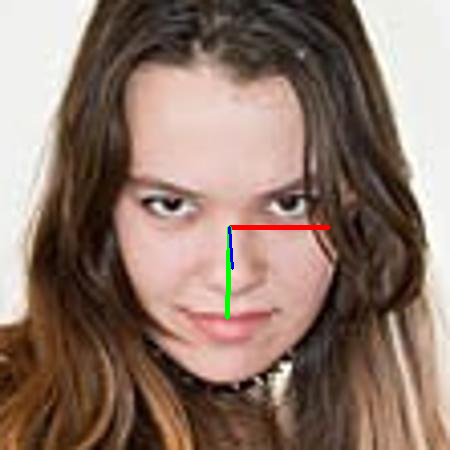

In [244]:
drawPos(test.index[0])

draw predicted poses

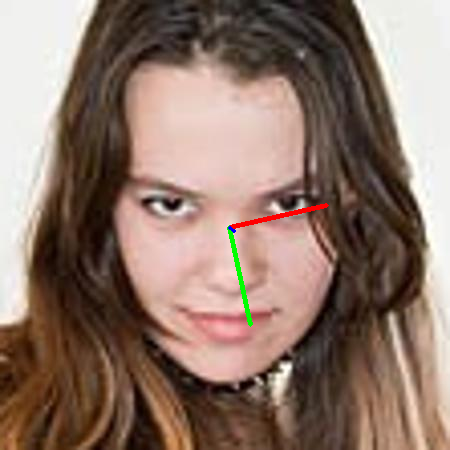

[-0.04453273323223096, -0.05700497568899705, -0.2159097229522101]


In [245]:
drawPos(test.index[0],customPose=preds[0].tolist())
print(preds[0].tolist())

Trying SVR

In [246]:
svr = MultiOutputRegressor(SVR(kernel='rbf'))
svr.fit(train.iloc[:,:-3],train.iloc[:,:-4:-1])

MultiOutputRegressor(estimator=SVR())

In [247]:
preds =svr.predict(test.iloc[:,:-3])

In [248]:
r2_score(test.iloc[:,:-4:-1],preds)

0.8433700937267887

draw original poses

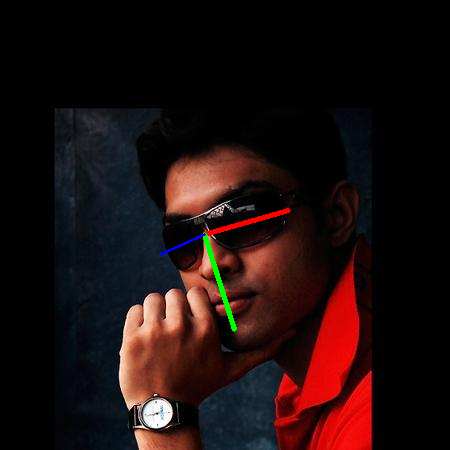

In [249]:
drawPos(test.index[14])

draw predicted poses

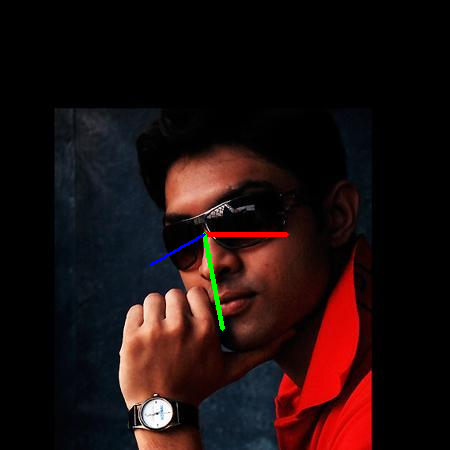

[-0.38870859060663665, 0.5727518929241828, -0.21733735682161992]


In [250]:
drawPos(test.index[14],customPose=preds[14].tolist())
print(preds[14].tolist())

the performance is not too bad although the r2 score is not high, but it takes a very long time

#### Train model on data after PCA

In [251]:
train_pca,test_pca = train_test_split(data_pca,test_size=0.2,random_state=42)

In [252]:
model_pca = MultiOutputRegressor(AdaBoostRegressor(n_estimators=60,learning_rate=0.3))
model_pca.fit(train_pca.iloc[:,:-3],train_pca.iloc[:,:-4:-1])

MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.3,
                                                 n_estimators=60))

In [253]:
preds_pca = model_pca.predict(test_pca.iloc[:,:-3])

In [254]:
r2_score(test_pca.iloc[:,:-4:-1],preds_pca)

0.5142244695990076

draw original poses

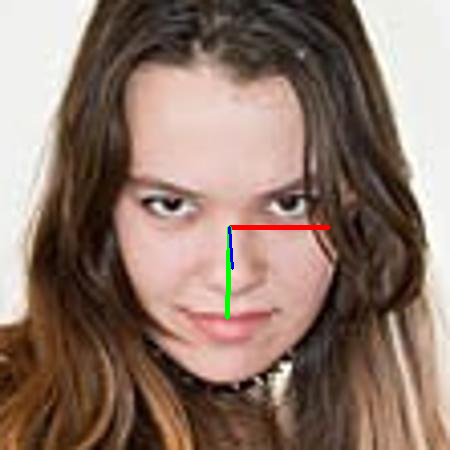

In [255]:
drawPos(test_pca.index[0])

draw predicted poses

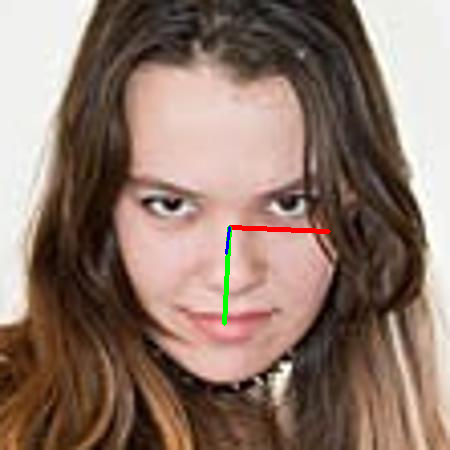

[-0.2689249654386626, 0.024691650206052244, 0.04285157841957475]


In [256]:
drawPos(test_pca.index[0],customPose=preds_pca[0].tolist())
print(preds_pca[0].tolist())

In [257]:
svr_pca = MultiOutputRegressor(SVR(kernel='rbf'))
svr_pca.fit(train_pca.iloc[:,:-3],train_pca.iloc[:,:-4:-1])

MultiOutputRegressor(estimator=SVR())

In [258]:
preds_pca =svr_pca.predict(test_pca.iloc[:,:-3])

In [259]:
r2_score(test_pca.iloc[:,:-4:-1],preds_pca)

0.8042021401340526

draw original poses

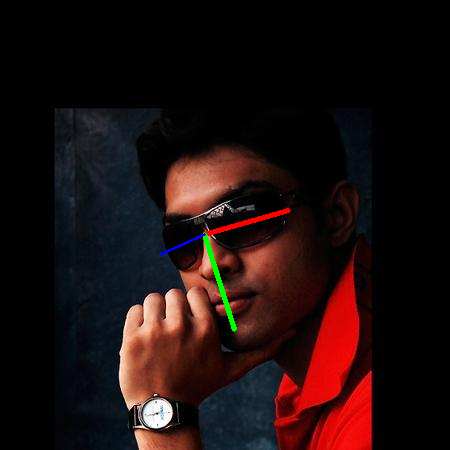

In [260]:
drawPos(test_pca.index[14])

draw predicted poses

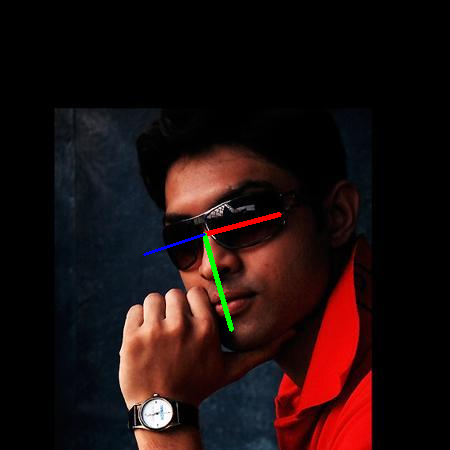

[-0.2589180900727239, 0.6393182316012279, -0.3561209562887189]


In [261]:

drawPos(test_pca.index[14],customPose=preds_pca[14].tolist())
print(preds_pca[14].tolist())

we can see that the model performs better after PCA

## Model Testing on New Data

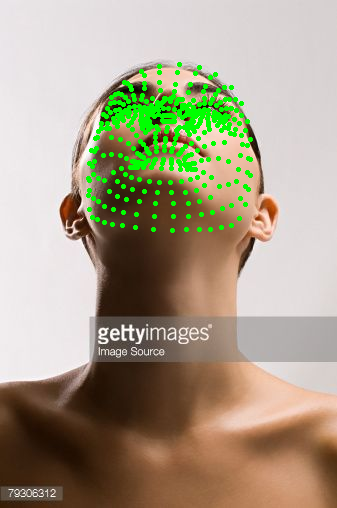

In [333]:
name = 'test9'
if os.path.isfile('/content/drive/MyDrive/Head-pose tests/'+name+'.jpg') == False:
  print('x')
landmarks = getLandMarks(name,path='/content/drive/MyDrive/Head-pose tests/')
#print(sum(landmarks[0]),sum(landmarks[1]))
landmarksX = []
landmarksY = []
landmarksX.append(landmarks[0])
landmarksY.append(landmarks[1])
drawPoints(name,path='/content/drive/MyDrive/Head-pose tests/')
  

In [334]:
X = pd.DataFrame(landmarksX,columns=["x"+str(i) for i in range(1,469)])
Y = pd.DataFrame(landmarksY,columns=["y"+str(i) for i in range(1,469)])
to_pred = pca.transform(pd.concat([X,Y],axis=1))
to_pred

array([[-0.37476817,  0.0844754 , -0.04634577, -1.11782867,  6.8867768 ,
        -0.25265577]])

In [335]:
preds =model_pca.predict(to_pred)
preds

array([[-0.04730229, -0.22535743,  0.05275225]])

In [336]:
img = draw_axis(name,preds[0].tolist()[0],preds[0].tolist()[1],preds[0].tolist()[2],path='/content/drive/MyDrive/Head-pose tests/', tdx=None, tdy=None, size = 100)

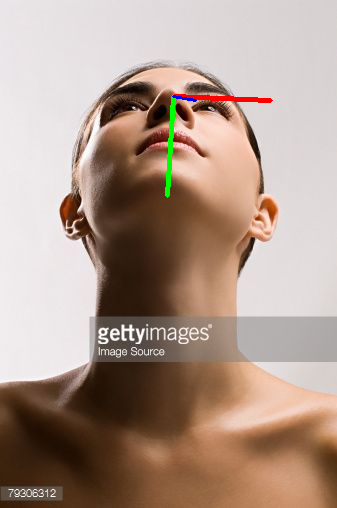

In [337]:
cv2_imshow(img)